In [4]:
# University of New Mexico
# Authors: Jered Dominguez-Trujillo and Sahba Tashakkori
# Date: May 5, 2020
# Description: Script to Analyze DB Data

# Import Statements
import pandas as pd
import numpy as np
import os
import urllib.request, json
import sys

from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
from scipy import stats
from datetime import date

In [3]:
def StateDailyCases(pathToCSV, States=None):
    df = pd.read_csv(pathToCSV)

    if States == None:
        States = df['STATE'].unique()

    _, axs = plt.subplots(2, 2, figsize=(15, 15))

    for State in States:
        Statedf = df[df['STATE'] == State]
        Statedf = Statedf.sort_values(by=['DATERECORDED'])
        
        # Calculating the diff of successive cumulative values to get per day data
        Positive = [Statedf['POSITIVE'].iloc[ii] - Statedf['POSITIVE'].iloc[ii - 1] for ii in range(1, len(Statedf['POSITIVE']))]
        Negative = [Statedf['NEGATIVE'].iloc[ii] - Statedf['NEGATIVE'].iloc[ii - 1] for ii in range(1, len(Statedf['NEGATIVE']))]
        Total = [Statedf['TOTAL'].iloc[ii] - Statedf['TOTAL'].iloc[ii - 1] for ii in range(1, len(Statedf['TOTAL']))]
        Death = [Statedf['DEATH'].iloc[ii] - Statedf['DEATH'].iloc[ii - 1] for ii in range(1, len(Statedf['DEATH']))]

        axs[0, 0].plot(list(range(1, len(Statedf))), Positive, '-o', label=State)
        axs[0, 1].plot(list(range(1, len(Statedf))), Negative, '-o', label=State)
        axs[1, 0].plot(list(range(1, len(Statedf))), Total, '-o', label=State)
        axs[1, 1].plot(list(range(1, len(Statedf))), Death, '-o', label=State)

    axs[0, 0].legend(loc='upper right')
    axs[0, 1].legend(loc='upper right')
    axs[1, 0].legend(loc='upper right')
    axs[1, 1].legend(loc='upper right')

    axs[0, 0].set_title('Daily Positive Tests')
    axs[0, 1].set_title('Daily Negative Tests')
    axs[1, 0].set_title('Daily Total Tests')
    axs[1, 1].set_title('Daily Deaths')
    axs[0, 0].set_xlabel('Days since May 6, 2020')
    axs[0, 1].set_xlabel('Days since May 6, 2020')
    axs[1, 0].set_xlabel('Days since May 6, 2020')
    axs[1, 1].set_xlabel('Days since May 6, 2020')
    axs[0, 0].set_ylabel('Total Positive Tests')
    axs[0, 1].set_ylabel('Total Negative Tests')
    axs[1, 0].set_ylabel('Total Tests')
    axs[1, 1].set_ylabel('Total Deaths')

    plt.savefig('diagrams/analysis/daily_tests.png', bbox_inches='tight')

In [4]:
def StateTotalCases(pathToCSV, States=None):
    df = pd.read_csv(pathToCSV)

    if States == None:
        States = df['STATE'].unique()

    _, axs = plt.subplots(2, 2, figsize=(15, 15))

    for State in States:
        Statedf = df[df['STATE'] == State]

        Statedf = Statedf.sort_values(by=['DATERECORDED'])

        axs[0, 0].plot(list(range(0, len(Statedf))), Statedf['POSITIVE'], '-o', label=State)
        axs[0, 1].plot(list(range(0, len(Statedf))), Statedf['NEGATIVE'], '-o', label=State)
        axs[1, 0].plot(list(range(0, len(Statedf))), Statedf['TOTAL'], '-o', label=State)
        axs[1, 1].plot(list(range(0, len(Statedf))), Statedf['DEATH'], '-o', label=State)

    axs[0, 0].legend(loc='upper right')
    axs[0, 1].legend(loc='upper right')
    axs[1, 0].legend(loc='upper right')
    axs[1, 1].legend(loc='upper right')

    axs[0, 0].set_title('Total Positive Tests')
    axs[0, 1].set_title('Total Negative Tests')
    axs[1, 0].set_title('Total Tests')
    axs[1, 1].set_title('Total Deaths')
    axs[0, 0].set_xlabel('Days since May 6, 2020')
    axs[0, 1].set_xlabel('Days since May 6, 2020')
    axs[1, 0].set_xlabel('Days since May 6, 2020')
    axs[1, 1].set_xlabel('Days since May 6, 2020')
    axs[0, 0].set_ylabel('Total Positive Tests')
    axs[0, 1].set_ylabel('Total Negative Tests')
    axs[1, 0].set_ylabel('Total Tests')
    axs[1, 1].set_ylabel('Total Deaths')

    plt.savefig('diagrams/analysis/total_tests.png', bbox_inches='tight')

In [5]:
def StateDailyPercentPositive(pathToCSV, States=None):
    df = pd.read_csv(pathToCSV)

    if States == None:
        States = df['STATE'].unique()

    plt.figure()

    for State in States:
        Statedf = df[df['STATE'] == State]

        Statedf = Statedf.sort_values(by=['DATERECORDED'])

        plt.plot(list(range(0, len(Statedf))), 100 * (Statedf['POSITIVE'] / Statedf['TOTAL']), '-o', label=State)

    plt.legend(loc='upper right')

    plt.title('Daily Positive Test Ratio (Positive Tests / Total Tests)')
    plt.xlabel('Days Since Data Collection Started (May 6, 2020)')
    plt.ylabel('Daily Positive Test Ratio [%]')

    plt.savefig('diagrams/analysis/percent_positive.png', bbox_inches='tight')

In [38]:
def MedAidTestCorr(pathToCSV, remove_outliers=True):
    df = pd.read_csv(pathToCSV)

    _ = plt.figure(figsize=(8, 8))

    costList = []
    testList = []

    for state in df.STATE:
        state_df = df[df['STATE'] == state]
        state_df = state_df.sort_values(by=['DATERECORDED']).iloc[-1]
        if remove_outliers:
            if state_df['COST'] < 0.4 * 10 ** 7 and state_df['TEST_TOTAL'] < 10 ** 6:
                costList.append(state_df['COST'] / 1000)
                testList.append(state_df['TEST_TOTAL'] / 1000)
            fName = 'diagrams/analysis/medaid_corr_no_outliers.png'
        else:
            costList.append(state_df['COST'] / 1000)
            testList.append(state_df['TEST_TOTAL'] / 1000)
            fName = 'diagrams/analysis/medaid_corr_outliers.png'
        
    costList = np.asarray(costList)
    testList = np.asarray(testList)

    slope, intercept, r_value, p_value, std_err = stats.linregress(costList, testList)
    predict_test = intercept + slope * costList

    plt.text(0, 0.9 * max(testList), 'Tests = %0.2f * MedAid + %0.2f' % (slope, intercept), fontsize=16)
    plt.text(0, 0.8 * max(testList), 'R-squared = %0.2f' % r_value ** 2, fontsize=16)

    plt.plot(costList, testList, 'o', markersize=4, label='State Data', color='k')
    plt.plot(costList, predict_test, 'g-', label='Linear Regression')
    plt.legend(loc='upper right')

    plt.title('Tests as a Function of Medical Aid Money Received')
    plt.xlabel("Aid Cost ($1000's)")
    plt.ylabel("Number of Tests (1000's)")

    plt.autoscale(True)
    plt.grid(True)
    plt.show()

    plt.savefig(fName, bbox_inches='tight')
    

In [2]:
def ICU_Death_CORR(pathToCSV='AnalysisData/icu_death.csv', remove_outliers=True,
                   file_name="./diagrams/analysis/death_icu.png"):
    import matplotlib
    df = pd.read_csv(pathToCSV)
    matplotlib.rcParams.update({'font.size': 12})
    _ = plt.figure(figsize=(8, 8))

    death_list = []
    icu_list = []

    for state in df.STATE:
        state_df = df[df['STATE'] == state]
    
        if state_df['TOTAL_POP'].iloc[0] != 0:
            death_per_capita = state_df['DEATH_TOT']/ state_df['TOTAL_POP'] * 100
            death_per_capita = death_per_capita.iloc[0]
            if remove_outliers and (death_per_capita >= 0.1):
                continue
            death_list.append(death_per_capita)
            icu_list.append(state_df['ICU_AVG'].iloc[0])
        
    death_list = np.array(death_list)
    icu_list = np.array(icu_list)
    slope, intercept, r_value, p_value, std_err = stats.linregress(icu_list, death_list)
    predict_death = intercept + slope * icu_list

    plt.text(0.3, 0.8 * max(death_list), 'Deaths = %0.2f * ICU_Rate + %0.2f' % (slope, intercept), fontsize=16)
    plt.text(0.3, 0.7 * max(death_list), 'R-squared = %0.2f' % r_value ** 2, fontsize=16)

    plt.plot(icu_list, death_list, 'o', markersize=4, label='State Data', color='k')
    plt.plot(icu_list, predict_death, 'g-', label='Linear Regression')
    plt.legend(loc='upper right')

    plt.title('Death per Capita  as a Function of ICU Occupancy Rate')
    plt.xlabel("ICU Occupancy Rate")
    plt.ylabel("Number of Deaths per Capita")

    plt.autoscale(True)
    plt.grid(True)
    plt.savefig(file_name, bbox_inches='tight')


In [10]:
def Prediction(csv_path, States=None):

    df = pd.read_csv(csv_path)
    feature_point_count = 2

    if States == None:
        States = df['STATE'].unique()
    
    for state in States:
        state_df = df[df.STATE==state]
        state_df = state_df.sort_values(by=['DATERECORDED'])
        time_values = np.array(list(range(len(state_df))))
        positive_results = state_df['POSITIVE']

        reshaped_x = time_values.reshape(len(time_values),1)
        reg = LR().fit(reshaped_x, positive_results)
        poly_features = PolynomialFeatures(degree=3)
        X_poly = poly_features.fit_transform(reshaped_x)
        poly_reg = LR().fit(X_poly, positive_results)
        future_time_values = np.concatenate((time_values,
                                            np.arange(len(time_values), len(time_values) + feature_point_count)))
        future_x_reshaped = future_time_values.reshape(len(future_time_values),1)

        predicted_pos_ls = reg.predict(future_x_reshaped)
        predicted_pos_pr = poly_reg.predict(poly_features.fit_transform(future_x_reshaped))

        plt.figure()
        plt.title('Positive Cases')
        plt.xlabel('Days Since Data Collection Started (May 6, 2020)')
        plt.ylabel('Positive Cases')


        plt.plot(future_time_values, predicted_pos_ls, "--or", label=state + "_Predicted(LS)" )    
        plt.plot(future_time_values, predicted_pos_pr, "--ob", label=state + "_Predicted(PR)" ) 
        plt.plot(time_values, state_df.POSITIVE,"--ok", label=state + "_Actual" )
        plt.legend()

        plt.savefig('diagrams/analysis/positive_trend_' + state + '.png', bbox_inches='tight')

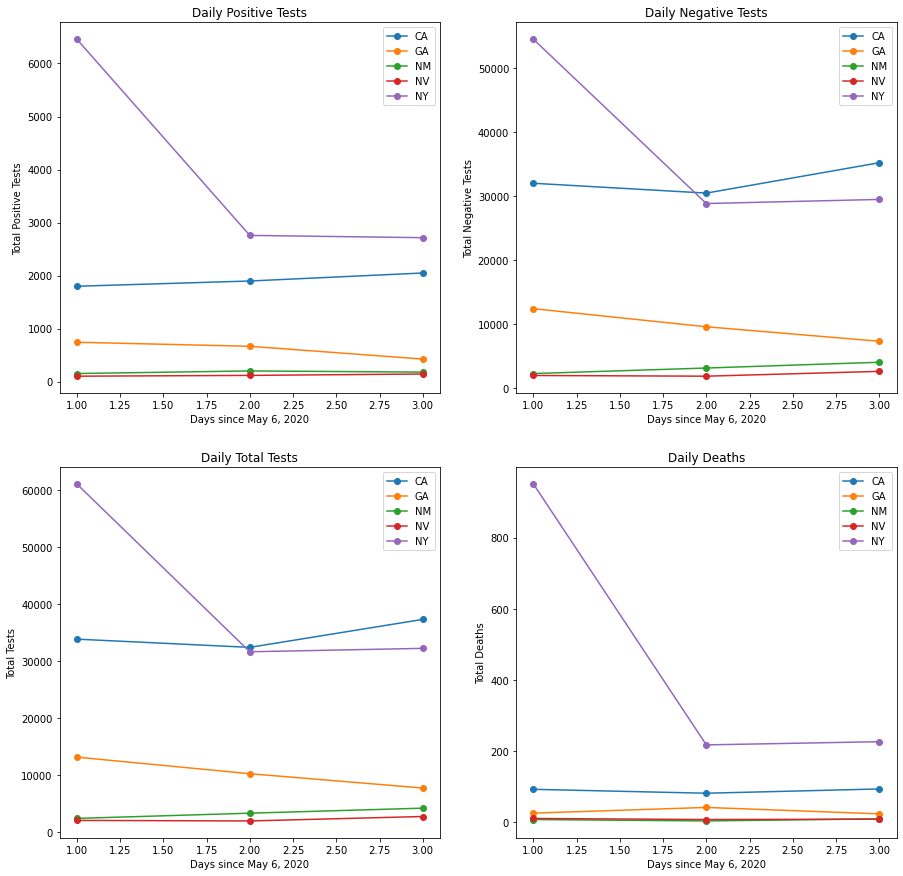

In [198]:
StateDailyCases('./AnalysisData/Q1_CASES_EXPORT.csv', ['CA', 'GA', 'NM', 'NV', 'NY'])

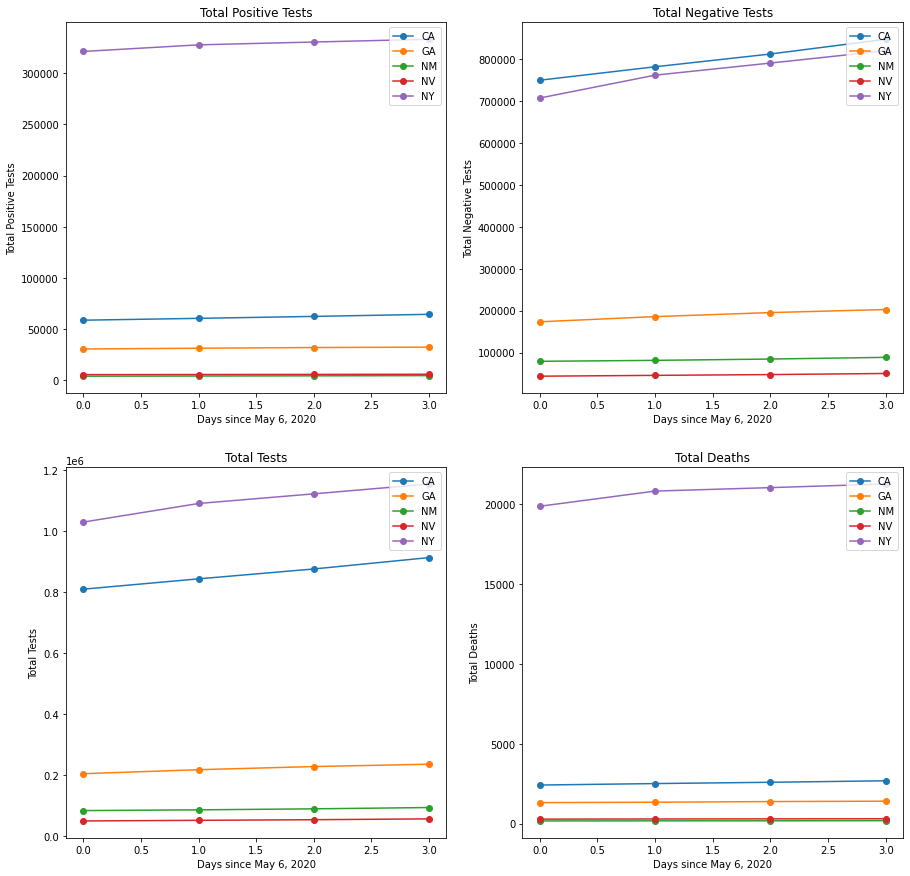

In [199]:
StateTotalCases('./AnalysisData/Q1_CASES_EXPORT.csv', ['CA', 'GA', 'NM', 'NV', 'NY'])

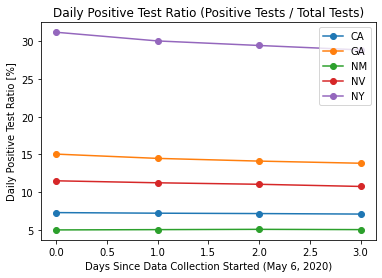

In [200]:
StateDailyPercentPositive('./AnalysisData/Q1_CASES_EXPORT.csv', ['CA', 'GA', 'NM', 'NV', 'NY'])

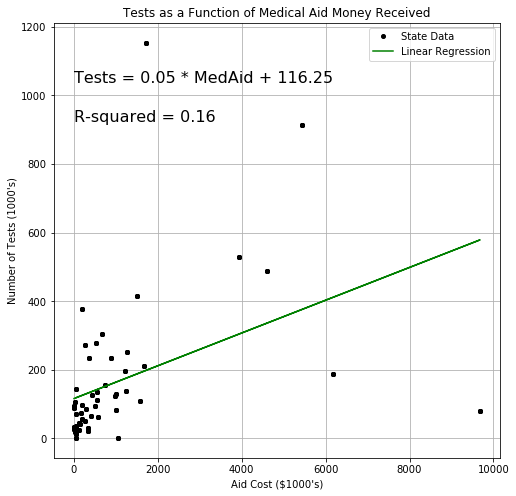

<Figure size 432x288 with 0 Axes>

In [39]:
MedAidTestCorr("./AnalysisData/Q2_MEDAID_EXPORT.csv", remove_outliers=False)

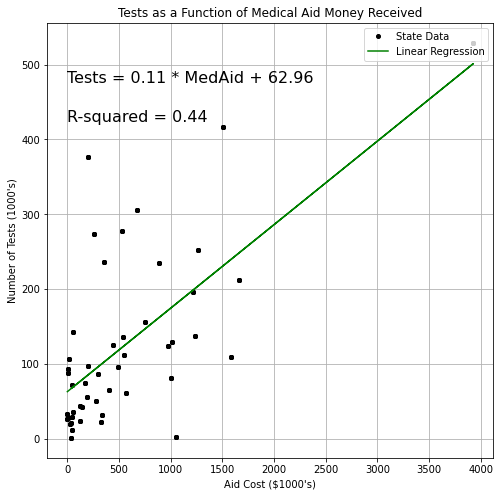

<Figure size 432x288 with 0 Axes>

In [202]:
MedAidTestCorr("./AnalysisData/Q2_MEDAID_EXPORT.csv", remove_outliers=True)

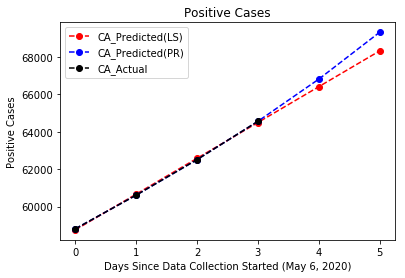

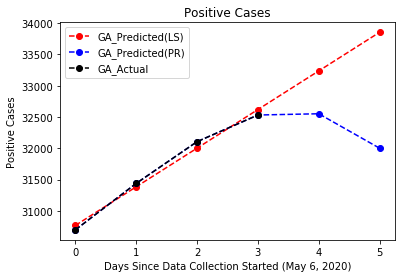

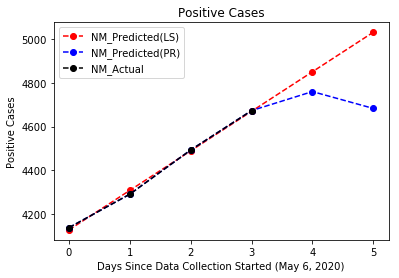

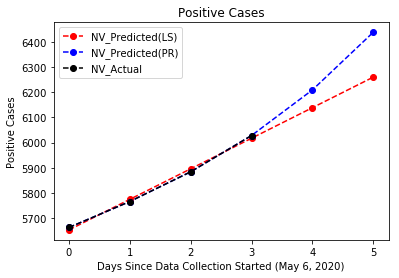

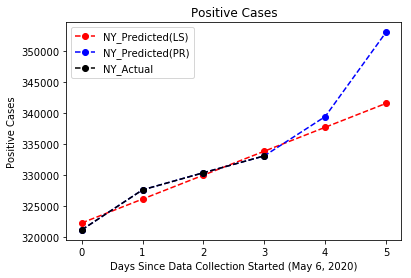

In [11]:
Prediction("./AnalysisData/Q1_CASES_EXPORT.csv", States=['CA', 'GA', 'NM', 'NV', 'NY'])

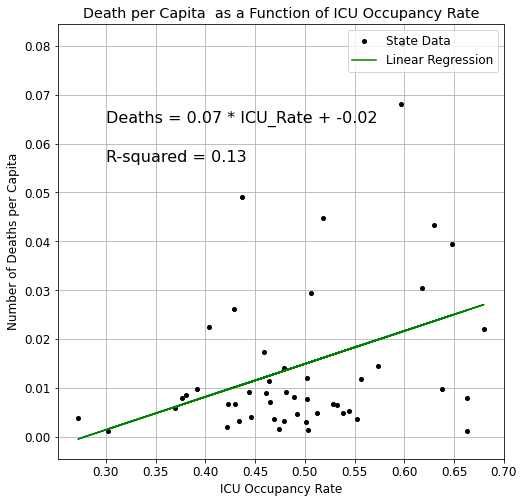

In [5]:
ICU_Death_CORR(pathToCSV='AnalysisData/Q4_ICU_DEATH.csv', remove_outliers=True, file_name="./dxiagrams/analysis/death_icu.png")